## Imports
All of the IceVision components can be easily imported with a single line.


In [1]:
from icevision.all import *

### Creating a model
Selections only take two simple lines of code. For example, to try the mmdet library using the retinanet model and the resnet50_fpn_1x backbone  could be specified by:
```
model_type = models.mmdet.retinanet
backbone = model_type.backbones.resnet50_fpn_1x(pretrained=True)
```
As pretrained models are used by default, we typically leave this out of the backbone creation step.

We've selected a few of the many options below. You can easily pick which option you want to try by setting the value of `selection`. This shows you how easy it is to try new libraries, models, and backbones.


In [2]:
# Just change the value of selection to try another model

selection = 0


extra_args = {}

if selection == 0:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x

elif selection == 1:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.retinanet
  backbone = model_type.backbones.resnet50_fpn

elif selection == 2:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_lite0
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 3:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.small
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = image_size

model_type, backbone, extra_args

(<module 'icevision.models.mmdet.models.retinanet' from '/home/ubuntu/miniconda3/lib/python3.8/site-packages/icevision/models/mmdet/models/retinanet/__init__.py'>,
 {})


Now it is just a one-liner to instantiate the model. If you want to try another *option*, just edit the line at the top of the previous cell.

In [3]:
# Instantiate the mdoel
# if mmdet.retinanet is selected above there will be some warnings but still works well
model = model_type.model(backbone=backbone(pretrained=True), num_classes=91, **extra_args)


/home/ubuntu/miniconda3/lib/python3.8/site-packages/mmcv/cnn/utils/weight_init.py:118: UserWarning: init_cfg without layer key, if you do not define override key either, this init_cfg will do nothing
  warnings.warn(


Use load_from_local loader
The model and loaded state dict do not match exactly

size mismatch for bbox_head.retina_cls.weight: copying a param with shape torch.Size([720, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([810, 256, 3, 3]).
size mismatch for bbox_head.retina_cls.bias: copying a param with shape torch.Size([720]) from checkpoint, the shape in current model is torch.Size([810]).


## Load Model

In [4]:
PATH = 'model-person.mm'
model.load_state_dict(torch.load(PATH))
# model.eval()


<All keys matched successfully>

### Prediction

Sometimes you want to have more control than `show_results` provides. You can construct an inference dataloader using `infer_dl` from any IceVision dataset and pass this to `predict_dl` and use `show_preds` to look at the predictions.

A prediction is returned as a dict with keys: `scores`, `labels`, `bboxes`, and possibly `masks`. 

Prediction functions that take a `detection_threshold` argument will only return the predictions whose score is above the threshold.

Prediction functions that take a `keep_images` argument will only return the (tensor representation of the) image when it is `True`. In interactive environments, such as a notebook, it is helpful to see the image with bounding boxes and labels applied. In a deployment context, however, it is typically more useful (and efficient) to return the bounding boxes by themselves.



> NOTE: For a more detailed look at inference check out the [inference tutorial](https://airctic.com/dev/inference/)

In [5]:
dataset_dir = './coco-2017-person'
annot = dataset_dir + '/train/labels.json'
img_dir = dataset_dir  + '/train/data'
# COCO parser: provided out-of-the-box
parser = parsers.COCOBBoxParser(annotations_filepath=annot, img_dir=img_dir)
infer_records, valid_records = parser.parse(RandomSplitter([1.0, 0.0]))

INFO     - Autofixing records | icevision.parsers.parser:parse:136



['person']
[    0.63058]
[<BBox (xmin:80.65115356445312, ymin:73.18173217773438, xmax:298.5531311035156, ymax:326.3138732910156)>]


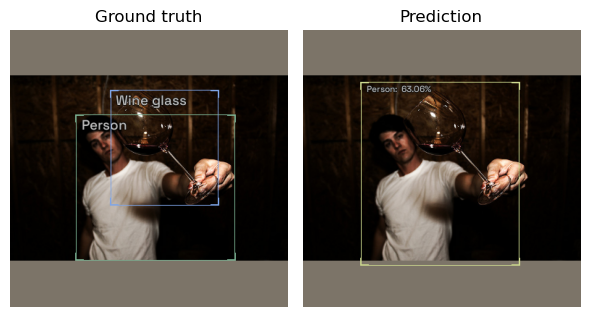

In [6]:
image_id = 86


image_size = 384
infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])
infer_ds = Dataset(infer_records[image_id:image_id+1], infer_tfms)
infer_dl = model_type.infer_dl(infer_ds, batch_size=1, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)


for x in preds[0].pred.detection.components:
    if 'ScoresRecordComponent' in str(x):
        scores = x.scores
        print(scores)
    if 'InstancesLabelsRecordComponent' in str(x):
        labels = x.labels
        print(labels)
    if 'BBoxesRecordComponen' in str(x):
        bboxes = x.bboxes
        print(bboxes)
        
        
show_preds(preds=preds[0:1])

